# Down-scaled multi-area model

<img src="model_construction.png" alt="Model overview" width="1000"/>

The code in this notebook implements the down-scaled version of spiking network model of macaque visual cortex developed at the Institute of Neuroscience and Medicine (INM-6), Research Center Jülich. The full-scale model has been documented in the following publications:

1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4)

2. Schuecker J, Schmidt M, van Albada SJ, Diesmann M & Helias M (2017)
   Fundamental Activity Constraints Lead to Specific Interpretations of the Connectome.
   PLOS Computational Biology, 13(2): e1005179. [https://doi.org/10.1371/journal.pcbi.1005179](https://doi.org/10.1371/journal.pcbi.1005179)

3. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359)

## Notebook Outline <a class="anchor" id="toc"></a>
* [S0. Configuration](#section_0)
* [S1. Parameterization](#section_1)
    * [1.1. Parameters to tune](#section_1_1)
* [S2. Model Configuration, Instantiation and Simulation](#section_2)
    * [2.1. Configuring model parameters](#section_2_1)
    * [2.2. Instantiate a multi-area model](#section_2_2)
    * [2.3. Predict firing rates from theory](#section_2_3)
    * [2.4. Extract and visualize interareal connectivity](#section_2_3)
    * [2.5. Run a simulation](#section_2_5)
* [S3. Visualization of Network Dynamics](#section_3) 
    * [3.1. Instantaneous and mean firing rate of simulated populations](#section_3_1)
    * [3.2. Normalized instantaneous firing rate over simulated areas](#section_3_2)
    * [3.3. Time-averaged firing rate over all populations](#section_3_3)
    * [3.4. Network dynamics in ground state or metastable state](#section_3_4)
* [Additional Notes](#section_4)

## S0. Configuration <a class="anchor" id="section_0"></a>

In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
%matplotlib inline
import numpy as np
import sys
import os
from IPython.display import display, HTML
import warnings

from multiarea_model import MultiAreaModel
from multiarea_model import Analysis
from config import base_path, data_path

sys.path.append('./figures/MAM2EBRAINS')


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# Jupyter notebook display format setting
style = """
<style>
table {float:left}
</style>
"""
display(HTML(style))

warnings.filterwarnings('ignore')

Go back to [Notebook Outline](#toc)

## S1. Parameterization <a class="anchor" id="section_1"></a>

### 1.1. Parameters to tune <a class="anchor" id="section_1_1"></a>

|Parameter|Default value|Value range/options|Value assigned|Description|
|:-------:|:-----------:|:-----------------:|:------------:|:---------:|
|scale_down_to|1.       |(0, 1.0]           |0.006         |$^1$       |
|cc_weights_factor|1.   |[1.0, 2.5]         |1.9           |$^2$       |
|areas_simulated|complete_area_list|Sublists of complete_area_list|complete_area_list|$^3$|
|replace_non_simulated_areas|None|None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'|'het_poisson_stat'|$^4$ |
|g        |-11.0 |$\leq -1.0$ |-11.0 |$^5$ |
|rate_ext |10.0  |$\geq 0.0$  |10.0  |$^6$ |


1. `scale_down_to` is the down-scaling factor that defines the ratio by which the full-scale multi-area model is reduced to a model with fewer neurons and indegrees. This reduction is essential to enable simulation on machines with limited computational power, ensuring that simulation results can be obtained in a relatively shorter timeframe. <br> If the value is `scale_down_to = 1.`, the full-scale network will be simulated. <br> In the pre-set down-scaled version, `scale_down_to = 0.006`. This setting reduces the number of neurons and indegrees to 0.6 % of their full-scale counterparts, facilitating simulation on a typical local machine. <br> **Warning**: This may not yield reasonable results from the network dynamics and is only meant to demonstrate the simulation workflow! <br> 

2. `cc_weights_factor` is the scaling factor that controls the cortico-cortical synaptic strength. <br> By default it is set to `1.0`, ensuring that inter- and intra-area synapses have equal strength. <br> **Important**: This factor plays a crucial role in transitioning the network activity from the ground to the metastable state.  In the full-scale network, the ground state and metastable state activities are achieved when this parameter is set to `1.0` and `1.9`, respectively.<br>

3. `areas_simulated` specifies the cortical areas to be included in the simulation process. Its default value is `complete_area_list` meaning all the areas in the complete_area_list will be simulated.
```python
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd', 'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd', 'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp', 'STPa', '46', 'AITd', 'TH']
```
The value assigned to `areas_simulated` can be any sublist of complete_area_list.

4. `replace_non_simulated_areas` defines how non-simulated areas will be replaced. <br> When all areas are included, it is set as `None` by default. <br> Other options are: `'hom_poisson_stat'`, `'het_poisson_stat'`, and `'het_current_nonstat'`.<br> `'hom_poisson_stat'` replaces the non-simulated areas by Poisson sources with the same global rate `rate_ext`. The `'het_poisson_stat'` and `'het_current_nonstat'` options use the loaded specific rates from `'replace_cc_input_source'`, which contains the area-specific firing rates of our full-scale simulation results. The difference is that `'het_poisson_stat'` replaces the non-simulated areas by Poisson spike trains and `'het_current_nonstat'` replaces it with a time-varying current input.

5. `g` defines the relative inhibitory synaptic strength (in relative units to the excitatory synaptic strength). By default: `-11.0`, as used in the full-scale network. `g = -1.0` means equal excitatory and inhibitory strengths, and `g < -1.0` results in stronger inhibition than excitation.

6. `rate_ext` defines the rate of the Poissonian spike generator (in spikes/s), by default: `10.0`. It also serves as one of the input parameters of the model. When a larger value is assigned to `rate_ext`, the excitatory background noise is increased.

In [4]:
# Downscaling factor
# Value range/options: (0, 1.], change it to 1. to run the full-scale network
scale_down_to = 0.006

# Scaling factor for cortico-cortical connections (Chi) 
# Value range/options: [1., 2.5], 
# A weight factor of 1.0 produces Ground state activity.
# A value larger than 1. reproduces the "Metastable" state activity, 
# 1.9 was assigned to produce results in Schmidt et al. (2018).
cc_weights_factor = 1.9

# Cortical areas included in the simulation
# Value range/options: any sublist of complete_area_list
# where complete_area_list is
complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd',
                      'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd',
                      'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp',
                      'STPa', '46', 'AITd', 'TH']
areas_simulated = complete_area_list
# areas_simulated = ['V1', 'V2']

# Firing rates used to replace the non-simulated areas
# Value range/options: None, 'hom_poisson_stat', 'het_poisson_stat', 'het_current_nonstat'
# If areas_simulated is complete_area_list, then replace_non_simulated_areas will be set as None 
# regardless of the value assigned below
replace_non_simulated_areas = 'het_poisson_stat'

# Relative inhibitory synaptic strength (in relative units), by default: -11.
g = -11.

# Rate of the Poissonian spike generator (in spikes/s), by default: 10.
rate_ext = 10.

Go back to [Notebook Outline](#toc)

## S2. Model Configuration, Instantiation and Simulation <a class="anchor" id="section_2"></a>

### 2.1. Configuring model parameters <a class="anchor" id="section_2_1"></a>

We try our best not to confuse users with too many parameters. So, the few parameters tunned will be automatically assigned in this section to properly run the simulation. 

However, if you want to explore the model, you can alter other parameters related to the network or simulation configuration by passing them in the `network_params` and `sim_params` dictionaries below. If this is not the case, you can execute the cell the way it is.

In [5]:
# Determine replace_cc_input_source
replace_cc_input_source = None                                               # By default, replace_cc_input_source is set to None
                                                                             # where areas_simulated is complete_area_list                                                           
if set(areas_simulated) != set(complete_area_list):                                                                                       
    if replace_non_simulated_areas == 'hom_poisson_stat':                   
        replace_cc_input_source = None
    elif replace_non_simulated_areas == 'het_poisson_stat' or replace_non_simulated_areas == 'het_current_nonstat':
        replace_cc_input_source = os.path.join(base_path, 'tests/fullscale_rates.json')
    else:
        raise Exception("'hom_poisson_stat', 'het_poisson_stat', or 'het_current_nonstat' should be assigned to replace_non_simulated_areas when not all areas are simulated!")

# Determine cc_weights_I_factor from cc_weights_factor
if cc_weights_factor == 1.0:                                                  # For ground state with cc_weights_factor as 1., 
    cc_weights_I_factor = 1.0                                                 # cc_weights_I_factor is set to 1.
elif cc_weights_factor > 1.0 and cc_weights_factor <= 2.5:                    # For metastable state with cc_weights_factor in (1., 2.5],
    cc_weights_I_factor = 2.0                                                 # cc_weights_I_factor is set to 2.
else:                                                                         # cc_weights_factor outside of (1., 2.5], raise error
    raise Exception("A value in range [1.0, 2.5] should be assigned to the parameter cc_weights_factor!")

# Connection parameters
conn_params = {
    'replace_non_simulated_areas': replace_non_simulated_areas,               # Whether to replace non-simulated areas by Poisson sources 
    'g': g,                                                                   # It sets the relative inhibitory synaptic strength, by default: -11.
    'replace_cc_input_source': replace_cc_input_source,                       # Specify the data used to replace non-simulated areas      
    'cc_weights_factor': cc_weights_factor,
    'cc_weights_I_factor': cc_weights_I_factor
}

# Input parameters
input_params = {
    'rate_ext': rate_ext                                                      # Rate of the Poissonian spike generator (in spikes/s), by default: 10.
} 

# Network parameters
network_params = {
    'N_scaling': scale_down_to,                                               # Scaling of population sizes, by default: 1. for full scale multi-area model
    'K_scaling': scale_down_to,                                               # Scaling of indegrees, by default: 1. for full scale multi-area model
    'fullscale_rates': os.path.join(base_path, 'tests/fullscale_rates.json'), # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params,                                             # Input parameters
    'connection_params': conn_params,                                         # Connection parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,                                       # Cortical areas included in the simulation
    't_sim': 2000.,                                                           # Simulated time (in ms), by default: 10.
    'rng_seed': 1                                                             # Global random seed
}

Go back to [Notebook Outline](#toc)

### 2.2. Instantiate a multi-area model <a class="anchor" id="section_2_2"></a>

In [6]:
M = MultiAreaModel(network_params, 
                   simulation=True,
                   sim_spec=sim_params,
                   theory=True)

Initializing network from dictionary.
RAND_DATA_LABEL 226


Customized parameters
--------------------
{'K_scaling': 0.006,
 'N_scaling': 0.006,
 'connection_params': {'cc_weights_I_factor': 2.0,
                       'cc_weights_factor': 1.9,
                       'g': -11.0,
                       'replace_cc_input_source': None,
                       'replace_non_simulated_areas': 'het_poisson_stat'},
 'fullscale_rates': '/opt/app-root/src/multi-area-model/tests/fullscale_rates.json',
 'input_params': {'rate_ext': 10.0}}
Simulation label: d7d699dad9f64bfb7893ef60997cb2c4
Copied files.
Initialized simulation class.


### 2.3. Predict firing rates from theory <a class="anchor" id="section_2_3"></a>

In [7]:
p, r = M.theory.integrate_siegert()

print("Mean-field theory predicts an average "
      "firing rate of {0:.3f} spikes/s across all populations.".format(np.mean(r[:, -1])))

Iteration: 0
Mean-field theory predicts an average firing rate of 28.624 spikes/s across all populations.


Go back to [Notebook Outline](#toc)

### 2.4. Extract and visualize interareal connectivity <a class="anchor" id="section_2_4"></a>

The connectivity and neuron numbers are stored in the attributes of the model class. 
- Neuron numbers are stored in `M.N` as a dictionary (and in `M.N_vec` as an array).

- Indegrees are stored in `M.K` as a dictionary (and in `M.K_matrix` as an array).<br>
  Dictionary of nodes indegrees organized as:<br>
  `{<source_area>: {<source_pop>: {<target_area>: {<target_pop>: indegree_values}}}}`

- Number of synapses can be accessed via `M.synapses` (and in `M.syn_matrix` as an array). <br>
  Dictionary of synapses that target neurons receive, it is organized as:<br>
  `{<source_area>: {<source_pop>: {<target_area>: {<target_pop>: number_of_synapses}}}}`

Comparable figure in our publications: <br>
1. Schmidt M, Bakker R, Hilgetag CC, Diesmann M & van Albada SJ <br>
   Multi-scale account of the network structure of macaque visual cortex
   Brain Structure and Function (2018), 223: 1409 [https://doi.org/10.1007/s00429-017-1554-4](https://doi.org/10.1007/s00429-017-1554-4) <br>
   **Fig. 4D Area-level connectivity of the model, based on data in a–c, expressed as relative indegrees for each target area.**

Initializing network from dictionary.
RAND_DATA_LABEL 9297


Customized parameters
--------------------
{}


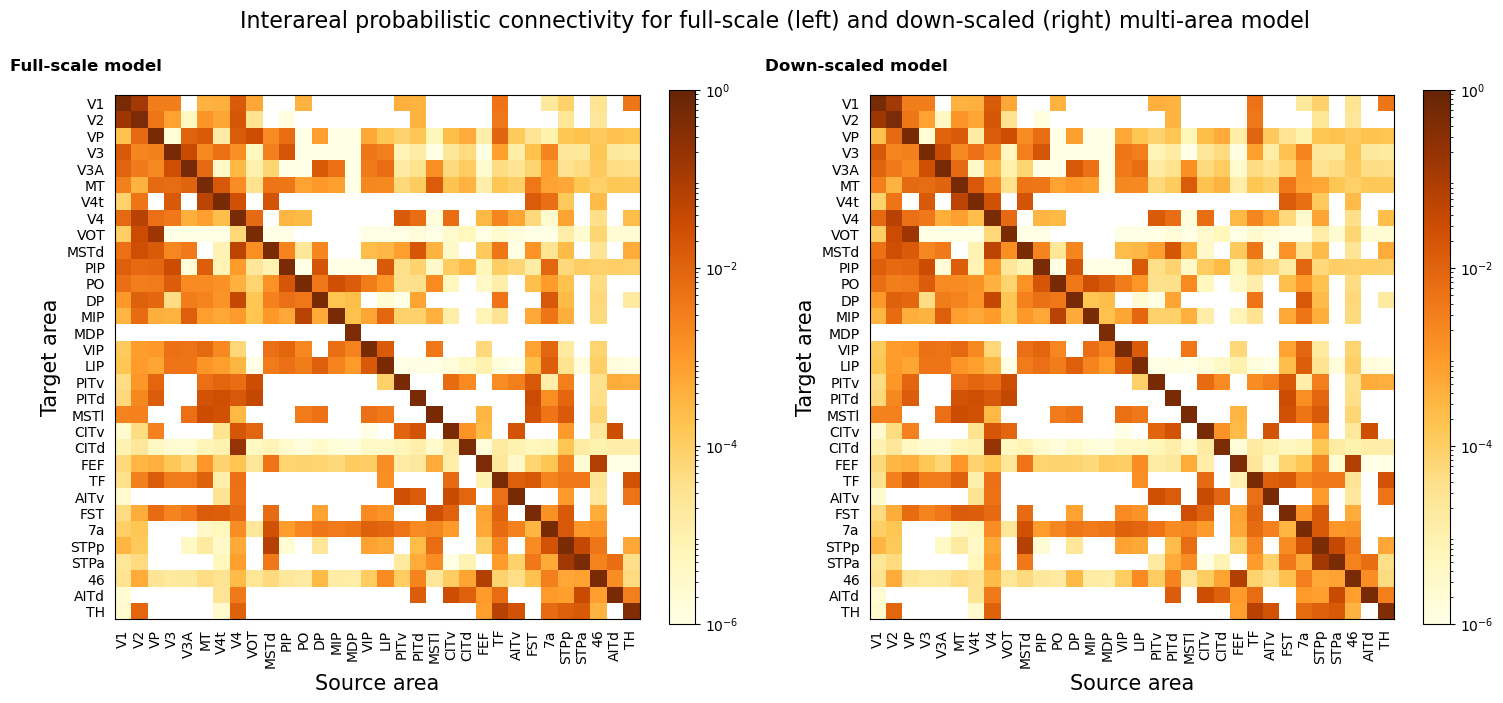

In [8]:
from M2E_visualize_interareal_connectivity import visualize_interareal_connectivity
visualize_interareal_connectivity(M)

Go back to [Notebook Outline](#toc)

### 2.5. Run a simulation <a class="anchor" id="section_2_5"></a>

In [9]:
# Run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
M.simulation.simulate()

Prepared simulation in 0.01 seconds.
Rank 0: created area V1 with 0 local nodes
Memory after V1 : 1560.80 MB
Rank 0: created area V2 with 0 local nodes
Memory after V2 : 1593.02 MB
Rank 0: created area VP with 0 local nodes
Memory after VP : 1628.02 MB
Rank 0: created area V3 with 0 local nodes
Memory after V3 : 1661.96 MB
Rank 0: created area V3A with 0 local nodes
Memory after V3A : 1685.62 MB
Rank 0: created area MT with 0 local nodes
Memory after MT : 1716.21 MB
Rank 0: created area V4t with 0 local nodes
Memory after V4t : 1746.14 MB
Rank 0: created area V4 with 0 local nodes
Memory after V4 : 1778.70 MB
Rank 0: created area VOT with 0 local nodes
Memory after VOT : 1808.94 MB
Rank 0: created area MSTd with 0 local nodes
Memory after MSTd : 1834.84 MB
Rank 0: created area PIP with 0 local nodes
Memory after PIP : 1860.79 MB
Rank 0: created area PO with 0 local nodes
Memory after PO : 1886.59 MB
Rank 0: created area DP with 0 local nodes
Memory after DP : 1911.03 MB
Rank 0: created

**Reminder**: The spike trains of simulated results are saved to the folder with path `./simulations/simulation label/recordings` where the simulation label displayed in the output of 2.2. All statistics describing network dynamics are computed from the saved spike trains.

Go back to [Notebook Outline](#toc)

## S3. Visualization of Network Dynamics <a class="anchor" id="section_3"></a>

**Important**: `cc_weights_factor` plays a crucial role in transitioning the network activity from the ground to the metastable state.  In the full-scale network, the ground state and metastable state activities are achieved when this parameter is set to `1.0` and `1.9`, respectively.

In [10]:
# Create an instance of Analysis to load data
A = Analysis(M, M.simulation, data_list=['spikes'], load_areas=None)

### 3.1. Instantaneous and mean firing rate of simulated populations <a class="anchor" id="section_3_1"></a>

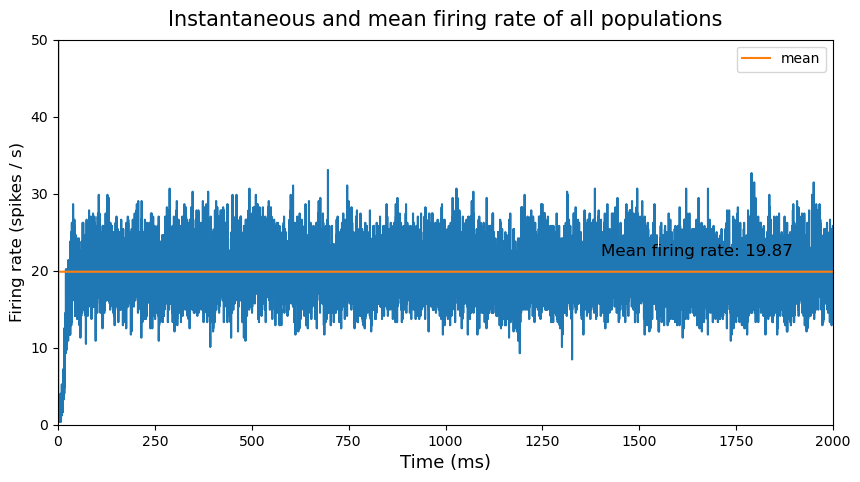

In [11]:
from M2E_visualize_firing_rate import plot_firing_rate
plot_firing_rate(M)

### 3.2. Normalized instantaneous firing rate over simulated areas <a class="anchor" id="section_3_2"></a>

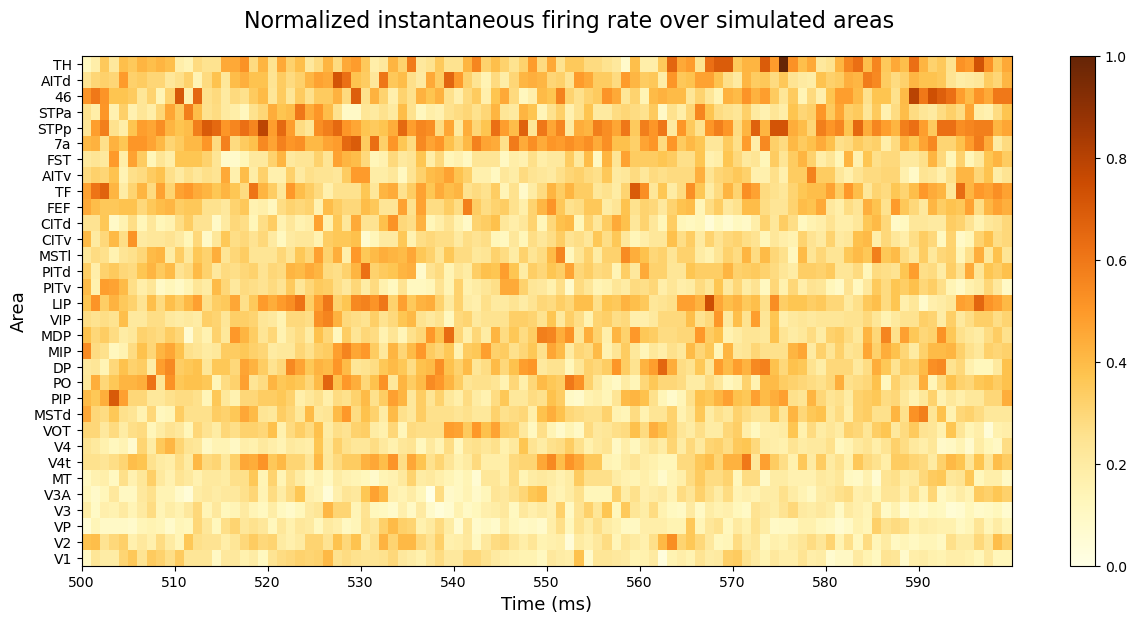

In [12]:
from M2E_visualize_firing_rate import plot_firing_rate_over_areas
plot_firing_rate_over_areas(M, data_path)

### 3.3. Time-averaged firing rate over simulated populations <a class="anchor" id="section_3_3"></a>

An overview of time-averaged firing rate over simulated populations encoded in colors with areas along x-axis and populations along y-axis.

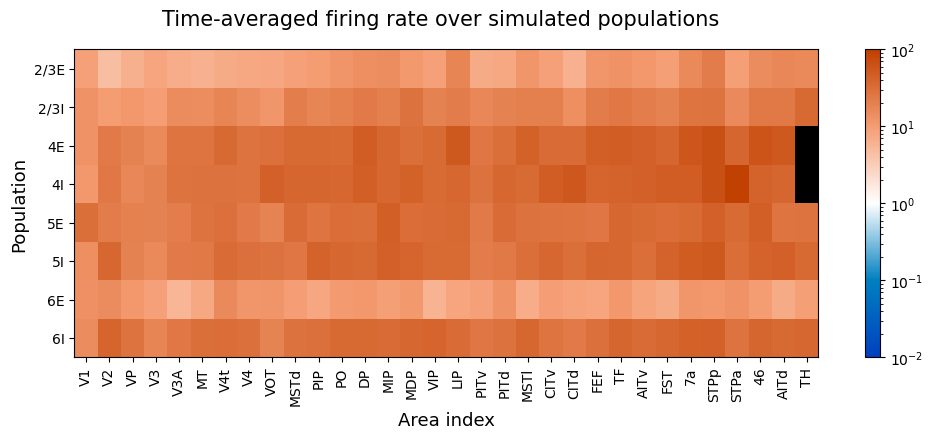

In [13]:
from M2E_visualize_time_ave_pop_rates import plot_time_averaged_population_rates
plot_time_averaged_population_rates(M, data_path)

### 3.4. Network dynamics <a class="anchor" id="section_3_4"></a>

Comparable figures in our publications: <br>
1. Schmidt M, Bakker R, Shen K, Bezgin B, Diesmann M & van Albada SJ (2018)
   A multi-scale layer-resolved spiking network model of
   resting-state dynamics in macaque cortex. PLOS Computational Biology, 14(9): e1006359. [https://doi.org/10.1371/journal.pcbi.1006359](https://doi.org/10.1371/journal.pcbi.1006359) <br>
   **Fig 3.  Ground state of the model.** <br>
   **Fig 5.  Resting state of the model with χ = 1.9 (metastable state).**

/opt/app-root/src/multi-area-model/./figures/MAM2EBRAINS/M2E_visualize_resting_state.py:301: UserWarning:FixedFormatter should only be used together with FixedLocator


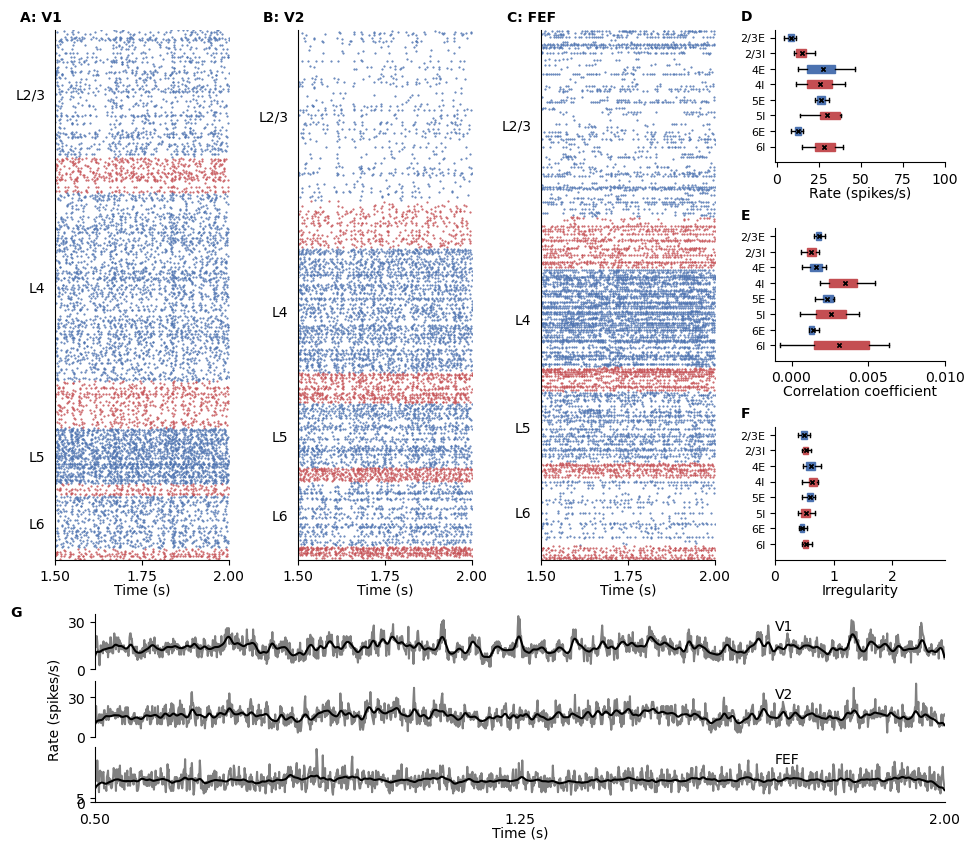

In [14]:
# Choose at most 3 areas from the areas_simulated to show their sipking activities
# By default, it's set as ['V1', 'V2', 'FEF'] when all areas from complete_area_list are simulated
raster_areas = ['V1', 'V2', 'FEF']

from M2E_visualize_resting_state import plot_resting_state
plot_resting_state(M, data_path, raster_areas)

Go back to [Notebook Outline](#toc)

## Additional Notes <a class="anchor" id="section_4"></a>

Go back to [Notebook Outline](#toc)